# iLykei Lecture Series

# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Reinforcement Learning

## Notebook 7: Car Rental Example

## Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2019

##### Main texts: 

Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc

Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning series), &copy; 2018 Richard S. Sutton, Andrew G. Barto, The MIT Press

This notebook discusses example 4.2 from Chapter 4 of the book by Sutton, Barto. 

## Jack's Car Rental

"Jack manages two locations for a nationwide car rental company.
Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he
rents it out and is credited $\$10$ by the national company. If he is out of cars at that location, then the
business is lost. Cars become available for renting the day after they are returned. To help ensure that
cars are available where they are needed, Jack can move them between the two locations overnight, at
a cost of $\$2$ per car moved."

**Assumptions**:

- Number of car rental requests is a Poisson random variable. Intensities of requests are: $\mu=3$ for locaton 1 and $\mu=4$ for location 2
- Number of cars returned to each location is also Poisson. Intensities are: $\mu=3$ for location 1 and $\mu=2$ for location 2
- Garages in both locations can park not more than 20 cars. Any car that does not fit will be returned to the nationwide company and disappear
- Maximum of 5 cars can be moved from one location to another in one night
- Discount rate is $\gamma=0.9$

State is the number of cars in each location at the end of the day $(n_1,n_2)$.
Action is the net number of cars moved between locations overnight.

## Solution by DP

In this section we use the [code](https://github.com/zy31415/jackscarrental) of Yang Zhang, modified for educational purposes.

In [43]:
%matplotlib inline
import numpy as np 
from scipy.stats import poisson

import matplotlib.pyplot as plt

The class bellow is designed for calculating Poisson probability mass function
$$poisson.pmf(k,\mu)=exp(-\mu)\frac{\mu^k}{k!}$$
and survival function (equal to 1 - cdf)
$$poisson.sf(k,\mu)=1 - \sum_{i=0}^{k}exp(-\mu)\frac{\mu^i}{i!}.$$
Once the above probabilities are calculated with parameter $\mu$, they are kept in the cache dictionary with the key $\mu$. The dictionary keeps only the first 25 probabilities since 
$$1-poisson.sf(4,25) \approx 2.67e-07 $$ and $\mu = 4$ is the maximal value we use in the example.
Caching results of `scipy.stats.poisson` significantly accelerates the search of optimal policy.

In [44]:
class Poisson(object):
    cache_pmf = {}
    cache_sf = {}
    cache = {}
    MAX_CUTOFF = 25

    @classmethod
    def pmf_series(cls, mu, cutoff):
        assert isinstance(mu, int), "mu should be an integer."
        assert isinstance(cutoff, int), "cutoff should be an integer"

        if (mu, cutoff) not in cls.cache:
            cls._calculate_pmf_series(mu, cutoff)

        return cls.cache[(mu, cutoff)]

    @classmethod
    def _calculate_pmf_series(cls, mu, cutoff):

        if mu not in cls.cache_pmf:
            print("Calculate poisson probabilities ...")
            cls.cache_pmf[mu] = poisson.pmf(np.arange(cls.MAX_CUTOFF + 1), mu)
            cls.cache_sf[mu] = poisson.sf(np.arange(cls.MAX_CUTOFF + 1), mu)

        out = np.copy(cls.cache_pmf[mu][:cutoff+1])
        out[-1] += cls.cache_sf[mu][cutoff]

        cls.cache[(mu, cutoff)] = out

Set the environment parameters.

In [45]:
capacity = 20  # maximal number of cars at each location
rental_reward = 10.  # reward for rent a car
moving_cost = 2.  # cost for moving car to another location overnight
# maximal number of cars that can be moved to another location in one night
max_moving = 5

# bad_action_cost should always be non-negative.
# when bad_action_cost == 0, bad action is not punished, 
bad_action_cost = 100.

request_mean_G1 = 3 # mean of rental requests at the first location
request_mean_G2 = 4 # mean of rental requests at the second location
return_mean_G1 = 3  # mean number of returns at the first location
return_mean_G2 = 2  # mean number of returns at the second location

discount_factor = 0.9

PolicyEvaluationError = 0.01

Function `rental_reward_given_cars` calculates the average rental reward with $s$ available cars; `expected_rental_reward` is the vectorized version of it.

In [46]:
def rental_reward_given_cars(s, mu):
    rewards = rental_reward * np.arange(s + 1)
    p = Poisson.pmf_series(mu, cutoff=s)
    return rewards.dot(p)

def expected_rental_reward(expected_request):
    return np.asarray([rental_reward_given_cars(s, expected_request)
                       for s in range(capacity + 1)])

The following function calculates transition probabilities used by function `bellman`.

In [47]:
def transition_probabilty(s, req, ret, action=0):
    '''    
    :param s: Current State
    :param req: Mean value of requests
    :param ret: Mean value of returns
    :param action: Action. Positive means move in. Negative means move out.
    :return: Transition probability.
    '''

    _ret_sz = max_moving + capacity

    p_req = Poisson.pmf_series(req, s)
    p_ret = Poisson.pmf_series(ret, _ret_sz)
    p = np.outer(p_req, p_ret)

    transp = np.asarray([p.trace(offset) 
                         for offset in range(-s, _ret_sz + 1)])

    assert abs(action) <= max_moving, "action can be large than %s." % max_moving

    # No cars are being moved
    if action == 0:
        transp[capacity] += sum(transp[capacity+1:])
        return transp[:capacity+1]

    # Move cars from Garage 1 to Garage 2
    if action > 0:
        transp[capacity-action] += sum(transp[capacity-action+1:])
        transp[capacity-action+1:] = 0

        return np.roll(transp, shift=action)[:capacity+1]

    # Move cars from Garage 2 to Garage 1
    action = -action
    transp[action] += sum(transp[:action])
    transp[:action] = 0

    transp[action+capacity] += sum(transp[action+capacity+1:])
    transp[action+capacity+1:] = 0

    return np.roll(transp, shift=-action)[:capacity+1]


Calculate value of state `(s1,s2)` with action `action`.

In [48]:
def bellman(action, s1, s2):
    transp1 = transition_probabilty(s1, request_mean_G1, return_mean_G1,
                                    -action)
    transp2 = transition_probabilty(s2, request_mean_G2, return_mean_G2,
                                    action)
    transp = np.outer(transp1, transp2)

    return reward1[s1] + reward2[s2] - expected_moving_cost(s1, s2, action) + \
           discount_factor * sum((transp * value).flat)

Policy evaluation. Function calculates new values for all states and compares them with the old ones. Early stopping in case of all absolute differences are less than `PolicyEvaluationError`.

In [49]:
def policy_evaluation():
    global value
    ''' Keep policy fixed and update value. '''
    while True:
        diff = 0.
        # Efficient multi-dimensional iterator object
        it = np.nditer([policy], flags=['multi_index'])

        while not it.finished:
            action = it[0]
            s1, s2 = it.multi_index
            temp = value[s1, s2]
            value[s1, s2] = bellman(action=action, s1=s1, s2=s2)
            diff = max(diff, abs(value[s1, s2] - temp))
            it.iternext()

        print(np.round(diff,3),end=' ')
        if diff < PolicyEvaluationError:
            break

Update policy according to the new values obtained by *policy_evaluation* fuction. Return *True* if policy is changed.

In [50]:
def policy_update():
    is_policy_changed = False

    it = np.nditer(policy, flags=['multi_index'])
    while not it.finished:
        s1, s2 = it.multi_index

        _max_val = -1
        _pol = None
        # find avalable action providing maximal value
        for act in range(-max_moving, max_moving + 1):
            _val = bellman(action=act, s1=s1, s2=s2)
            if _val > _max_val:
                _max_val = _val
                _pol = act

        if policy[s1, s2] != _pol:
            is_policy_changed = True
            policy[s1, s2] = _pol

        it.iternext()
    return is_policy_changed


We used numpy nditer itereator in the above function. It is efficient multi-dimensional iterator object to iterate over arrays. Here is an easy example illustrating how it works.

In [51]:
p = np.arange(6).reshape((3,2))

it = np.nditer(p, flags=['multi_index'])

while not it.finished:
    s1, s2 = it.multi_index
    print(s1, s2,it[0])
    it.iternext()

0 0 0
0 1 1
1 0 2
1 1 3
2 0 4
2 1 5


The following two functions are used to calculate expected moving cost.

In [52]:
def expected_moving_cost(s1, s2, action):
    if action == 0:
        return 0.

    # moving from state s1 into state s2
    if action > 0:
        p = transition_probabilty(s1, request_mean_G1, return_mean_G1)
        cost = gen_move_cost_array(action)
        return cost.dot(p)

    # moving from state s2 into state s1
    p = transition_probabilty(s2, request_mean_G2, return_mean_G2)
    cost = gen_move_cost_array(action)
    return cost.dot(p)

def gen_move_cost_array(action):
    '''
    Generate an array based on which costs of move is calculated.

    If action > available cars, then this action is considered as a bad action.

    when bad_move_cost == 0, bad action is not punished. The system will move max possible cars.

    When bad_move_cost >0, bad action is punished indicated by this variable.

    :param action: Number of cars that will be moved from Garage 1 to Garage 2.
    :return: 
    '''
    _action = abs(action)

    # Don't punish bad action:
    if bad_action_cost == 0:
        cost = np.asarray(
            [ii if ii < _action else _action for ii in range(capacity+1)]
        ) * moving_cost

    # bad action is punished
    else:
        cost = np.asarray(
            [bad_action_cost if ii < _action else _action for ii in range(capacity + 1)]
        ) * moving_cost
    return cost

Let the state be the number of cars at each location. Action **a** is the number of cars to be moved from Garage 1 to Garage 2 (if **a**<0 we move **-a** cars from Garage 2 to Garage 1). Initiate all state values and policy to zero.

In [53]:
value = np.zeros((capacity + 1,capacity + 1))
policy = np.zeros_like(value, int)

Get expected rental reward.

In [54]:
reward1 = expected_rental_reward(request_mean_G1)
reward2 = expected_rental_reward(request_mean_G2)

Calculate poisson probabilities ...
Calculate poisson probabilities ...


Run value iteration algorithm.

In [55]:
for k in np.arange(4):
    print(f'iteration {k}: policy_evaluation')
    policy_evaluation()
    print('\npolicy_update')
    policy_update()

print(policy)

iteration 0: policy_evaluation
Calculate poisson probabilities ...
193.349 134.004 90.452 67.598 53.585 41.721 32.72 26.088 21.778 18.318 15.367 12.861 10.739 8.949 7.443 6.18 5.124 4.243 3.509 2.899 2.393 1.974 1.627 1.34 1.104 0.908 0.747 0.615 0.505 0.415 0.341 0.281 0.23 0.189 0.155 0.128 0.105 0.086 0.071 0.058 0.048 0.039 0.032 0.026 0.022 0.018 0.015 0.012 0.01 
policy_update
iteration 1: policy_evaluation
46.655 3.193 1.618 1.177 0.978 0.856 0.715 0.589 0.484 0.397 0.325 0.267 0.219 0.179 0.147 0.12 0.099 0.081 0.066 0.054 0.045 0.037 0.03 0.025 0.02 0.016 0.014 0.011 0.009 
policy_update
iteration 2: policy_evaluation
4.675 2.713 1.72 1.099 0.692 0.436 0.281 0.193 0.146 0.111 0.086 0.069 0.057 0.047 0.038 0.031 0.026 0.021 0.017 0.014 0.012 0.009 
policy_update
iteration 3: policy_evaluation
0.397 0.143 0.078 0.05 0.031 0.019 0.012 0.007 
policy_update
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -

Plot results

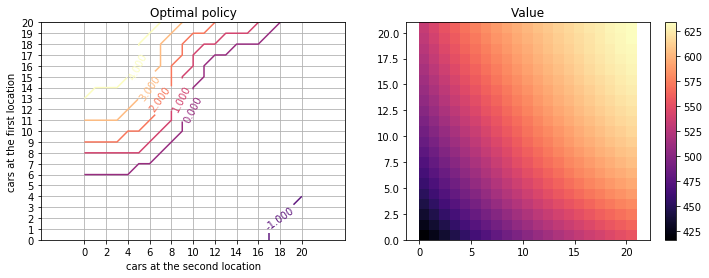

In [56]:
plt.rcParams["figure.figsize"] = 12,4
plt.subplot(121)

cmap = plt.cm.get_cmap('magma') 
CS = plt.contour(policy, levels=range(-3, 5),cmap=cmap)
plt.clabel(CS, fontsize=10)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(0,21,2))
plt.yticks(range(21))
plt.xlabel('cars at the second location')
plt.ylabel('cars at the first location')
plt.title('Optimal policy')
plt.grid(True)

plt.subplot(122)
plt.pcolor(value,cmap=cmap)
plt.colorbar()
plt.axis('equal')
plt.title('Value')
plt.show()

The optimal policy is not symmetric. If the first garage full and the second one is empty we should move 5 cars overnight while in inverse situation the optimal action is to move only 2 cars to the empty garage. The reason is that rental requests to the second garage are more frequent.